In [1]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, chi2
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

warnings.filterwarnings("ignore")
df = pd.read_csv('framingham.csv', encoding='latin-1')

# Filling out missing values
df['BPMeds'].fillna(0, inplace = True)
df['glucose'].fillna(df.glucose.mean(), inplace = True)
df['totChol'].fillna(df.totChol.mean(), inplace = True)
df['education'].fillna(1, inplace = True)
df['BMI'].fillna(df.BMI.mean(), inplace = True)
df['heartRate'].fillna(df.heartRate.mean(), inplace = True)
df.dropna(inplace= True)

# drop if there is duplicate
df.drop_duplicates(inplace=True)
df = pd.get_dummies(df)

In [2]:
df.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


Get Relations of the columns

In [3]:
x = df.iloc[:, 0:len(df.iloc[0])-1]  #independent columns
y = df.iloc[:, -1]  # dependent columns

topfeatures = SelectKBest(score_func=chi2, k=10)
fit = topfeatures.fit(x,y)
df_scores = pd.DataFrame(fit.scores_)
df_columns = pd.DataFrame(x.columns)

feature_rank = pd.concat([df_columns, df_scores], axis=1)
feature_rank.columns = ['Specs','Score'] 
print(feature_rank.nlargest(12,'Score'))

              Specs       Score
10            sysBP  723.869467
14          glucose  396.876778
1               age  320.492036
9           totChol  239.486113
4        cigsPerDay  221.649812
11            diaBP  150.716082
7      prevalentHyp   91.247637
8          diabetes   38.817649
5            BPMeds   30.469417
0              male   19.042170
6   prevalentStroke   15.996757
12              BMI   14.189893


In [4]:
df_framingham_clean = df[feature_rank.nlargest(12,'Score').Specs.tolist()]

Plot boxplots of all top 12 features in order to eliminate outliers

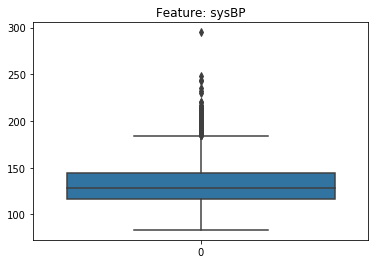

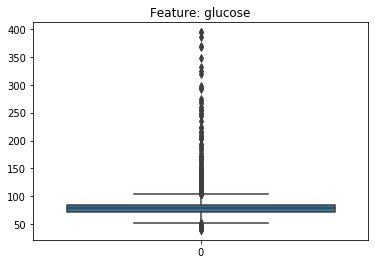

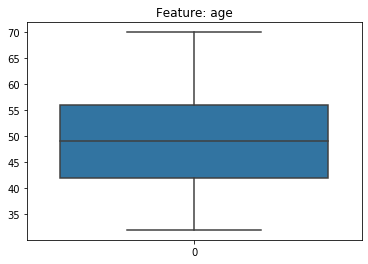

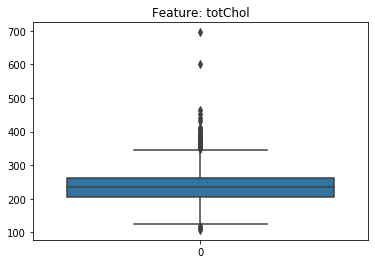

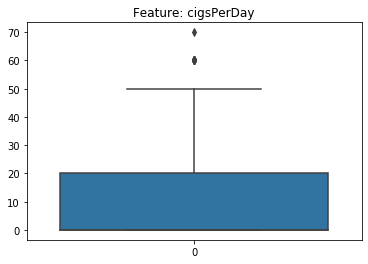

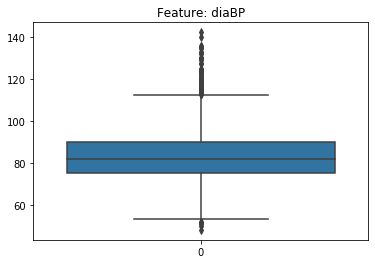

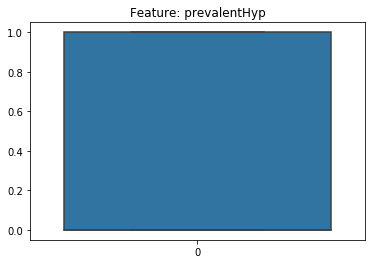

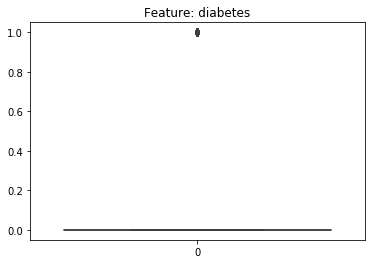

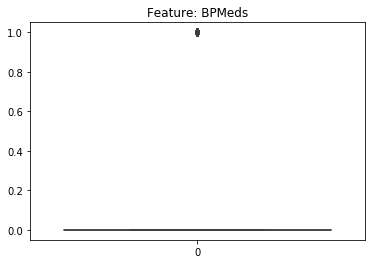

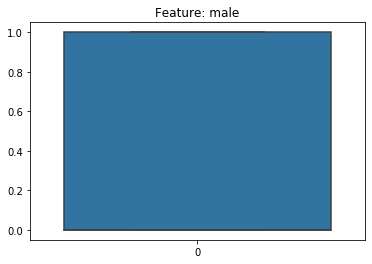

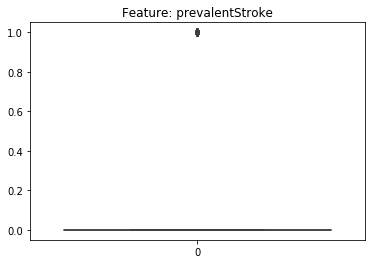

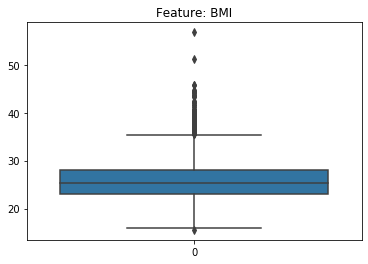

In [5]:
# [col for col in df if np.isin(df[col].unique(), [0, 1]).all()]
for column in df_framingham_clean.columns:
    sns.boxplot(data=df_framingham_clean[column]).set_title('Feature: ' + column)
#     plt.savefig(column + '_outlier.png', dpi=100)
    plt.show()

Eliminate outliers manually

In [6]:
df = df.loc[df.sysBP < 260]
df = df.loc[df.totChol < 510]
df = df.loc[df.cigsPerDay < 55]
df = df.loc[df.BMI < 49]

Train test split from clean data

In [7]:
labels = np.array(df['TenYearCHD'])
df = df.drop('TenYearCHD', axis=1)

df = df[feature_rank.nlargest(12,'Score').Specs.tolist()]

train_x, test_x, train_y, test_y = train_test_split(df, labels, test_size=0.25, random_state=42)

print ("Train_x Shape: ",train_x.shape)
print ("Train_y Shape: ", train_y.shape)
print ("Test_x Shape: ", test_x.shape)
print ("Test_y Shape: ", test_y.shape)

Train_x Shape:  (3145, 12)
Train_y Shape:  (3145,)
Test_x Shape:  (1049, 12)
Test_y Shape:  (1049,)


In [8]:
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier



def get_models():
    
    lr = LogisticRegression(C=100, random_state=42, solver='liblinear')
    nn = MLPClassifier((80, 10), early_stopping=False, random_state=42)
    rf = RandomForestClassifier(n_estimators=300, random_state=42, max_depth=3)
    clf = BaggingClassifier(base_estimator=SVC(), n_estimators=100, random_state=42)
    nb = GaussianNB()
    svc = SVC(C=100, probability=True)
    knn = KNeighborsClassifier(n_neighbors=3)
    
    models = {'svm': svc,
              'knn': knn,
              'naive bayes': nb,
              'mlp-nn': nn,
              'random forest': rf,
              'logistic': lr,
              'bagging': clf
              }

    return models


def prediction(model_list):
    
    pred = np.zeros((test_y.shape[0], len(model_list)))
    pred = pd.DataFrame(pred)

    print("Calculating predictions..")
    cols = list()
    for i, (name, m) in enumerate(models.items()):
        print("Model: %s" % name)
        m.fit(train_x, train_y)
        pred.iloc[:, i] = m.predict_proba(test_x)[:, 1]
        cols.append(name)
        
    pred.columns = cols
    return pred


def roc_auc_func(y, pred):

    print("Calculating roc auc scores..")
    for i in pred.columns:
        score = roc_auc_score(y, pred.loc[:, i])
        print("%-26s: %.3f" % (i, score))

    
models = get_models()
pred = prediction(models)
roc_auc_func(test_y, pred)

Calculating predictions..
Model: svm
Model: knn
Model: naive bayes
Model: mlp-nn
Model: random forest
Model: logistic
Model: bagging
Calculating roc auc scores..
svm                       : 0.629
knn                       : 0.583
naive bayes               : 0.712
mlp-nn                    : 0.673
random forest             : 0.710
logistic                  : 0.728
bagging                   : 0.508


Calculating unique combinations of all model list

In [10]:
from itertools import combinations  
columns_list = []
for i in range(2,len(pred.columns) + 1):
    comb = list(combinations(pred.columns, i))
    for i in range(1, len(comb)):
        columns_list.append(list(comb[i]))


Select best models by simply averaging their roc auc scores.

In [11]:
best = 0
for i in columns_list:
    pred_1 = pred[i]
    temp = roc_auc_score(test_y, pred_1.mean(axis=1))
    if temp > best:
        best = temp
        print("Ensemble %s ROC-AUC score: %.3f" % (i, roc_auc_score(test_y, pred_1.mean(axis=1))))

Ensemble ['svm', 'naive bayes'] ROC-AUC score: 0.709
Ensemble ['svm', 'random forest'] ROC-AUC score: 0.710
Ensemble ['svm', 'logistic'] ROC-AUC score: 0.729
Ensemble ['mlp-nn', 'logistic'] ROC-AUC score: 0.732
Ensemble ['svm', 'mlp-nn', 'logistic'] ROC-AUC score: 0.733


Select best models by ensembling with Voting Classifier method then recalculate roc auc score. 
['svm', 'mlp-nn', 'logistic'] models yielded ROC-AUC score: 0.733

optional - takes a bit longer

In [15]:
from sklearn.ensemble import VotingClassifier
ensemble = []
best = 0
for i in columns_list:
    estimator = []
    for j in i:
        estimator.append((j, models[j]))
        votingC = VotingClassifier(estimators=estimator, voting='soft', n_jobs=4)
        votingC = votingC.fit(train_x, train_y)
        result = pd.Series(votingC.predict_proba(test_x)[::,1], name="TenYearCHD")
        temp = roc_auc_score(test_y, result)
        if temp > best:
            best = temp
            ensemble = i
            print("Ensemble %s ROC-AUC score: %.3f" % (i, roc_auc_score(test_y, result)))

Ensemble ['svm', 'naive bayes'] ROC-AUC score: 0.629
Ensemble ['svm', 'naive bayes'] ROC-AUC score: 0.710
Ensemble ['svm', 'random forest'] ROC-AUC score: 0.711
Ensemble ['svm', 'logistic'] ROC-AUC score: 0.729
Ensemble ['mlp-nn', 'logistic'] ROC-AUC score: 0.732
Ensemble ['svm', 'mlp-nn', 'logistic'] ROC-AUC score: 0.733


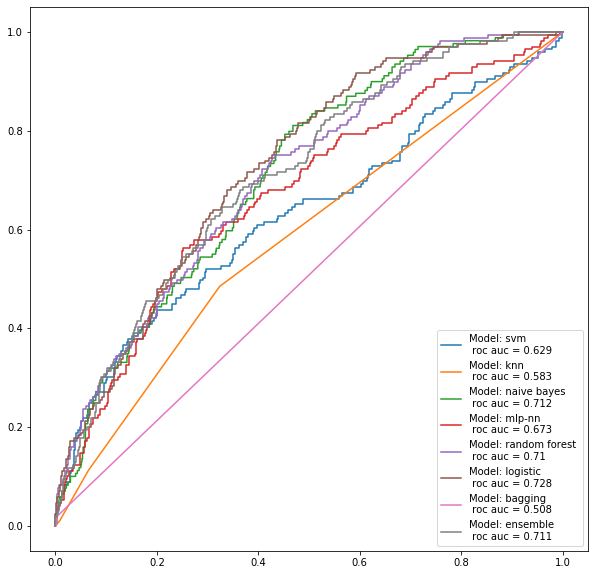

In [38]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
def plot_roc_curve(pred, i):

    fpr, tpr, _ = metrics.roc_curve(test_y,  pred)
    auc = metrics.roc_auc_score(test_y, pred)
    plt.plot(fpr, tpr, label= "Model: " + i + " \n roc auc = "+str(round(auc, 3)))

# Best roc auc score ensemble
ensemble = ['svm', 'mlp-nn', 'logistic']
votingC = VotingClassifier(estimators=estimator, voting='soft', n_jobs=4)
votingC = votingC.fit(train_x, train_y)
result = pd.Series(votingC.predict_proba(test_x)[::,1], name="TenYearCHD")

# Plot all individual models
for i in pred.columns:
    plot_roc_curve(pred[i], i)

# Plot ensemble model
plot_roc_curve(result, 'ensemble')

plt.rcParams["figure.figsize"] = (10, 10)
plt.legend(loc=4)
# plt.savefig('roc_auc.png', dpi=100)
plt.show()

# plt.close()

<module 'matplotlib.pyplot' from 'C:\\Users\\batuhan.organ\\AppData\\Local\\Programs\\Python\\Python37\\lib\\site-packages\\matplotlib\\pyplot.py'>

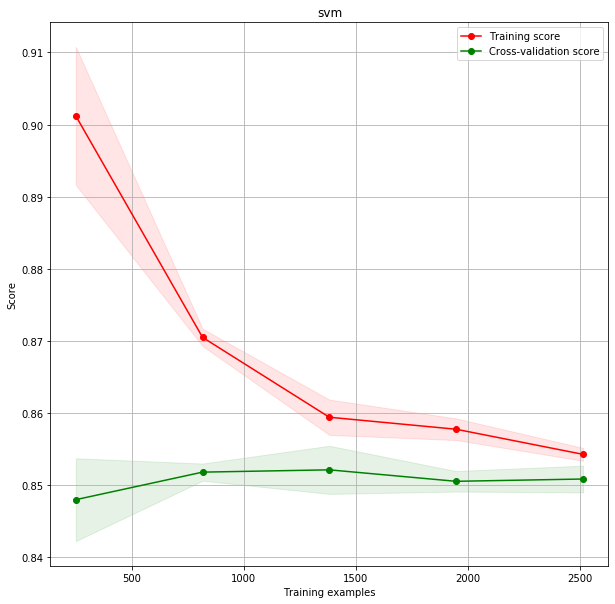

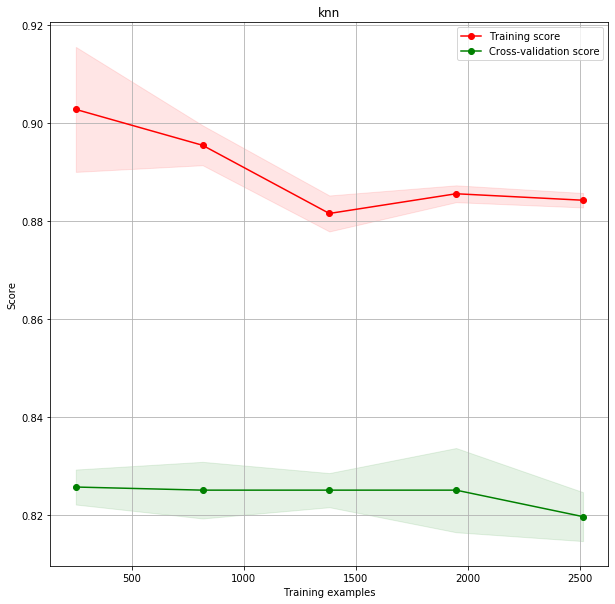

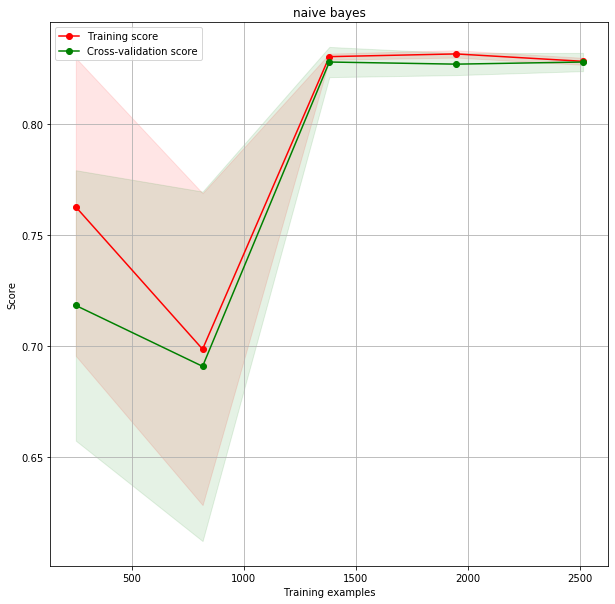

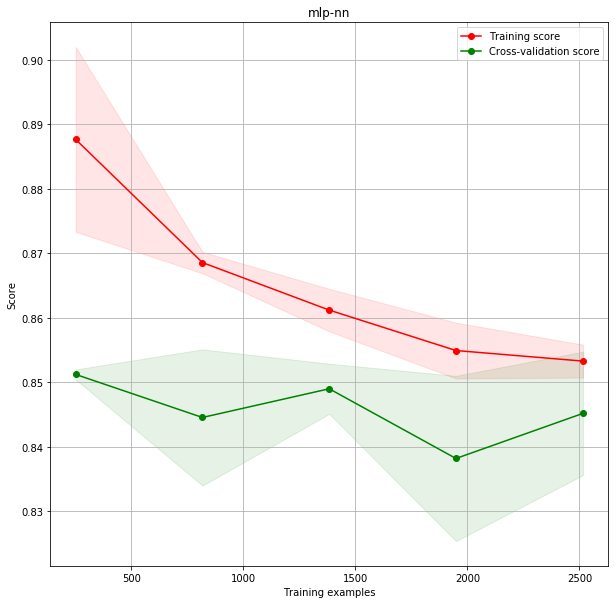

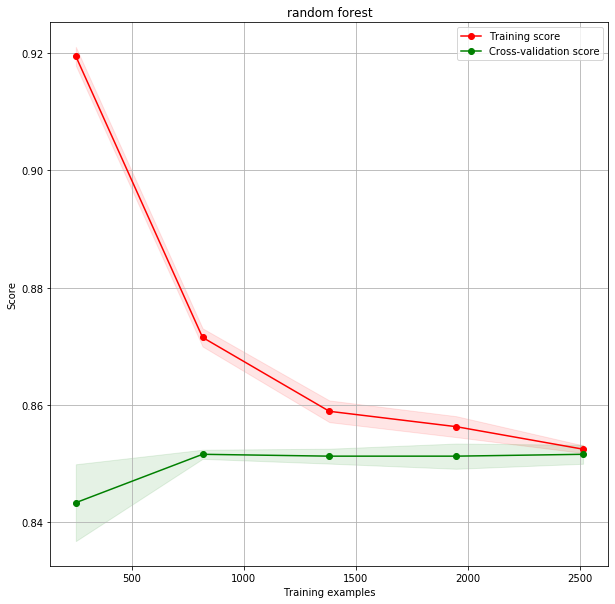

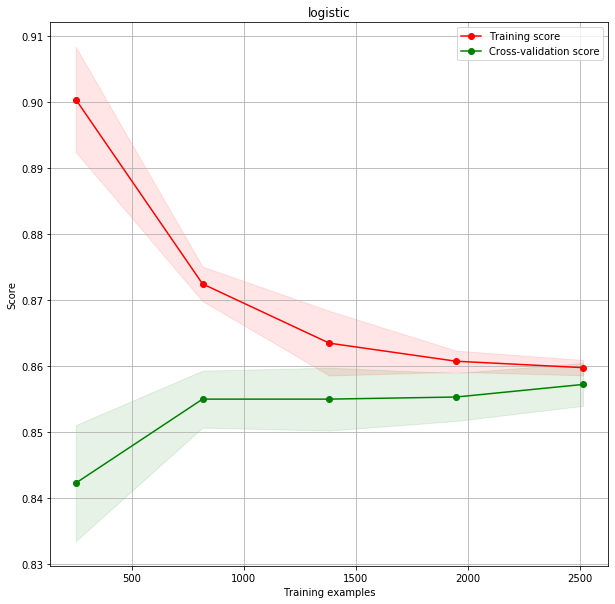

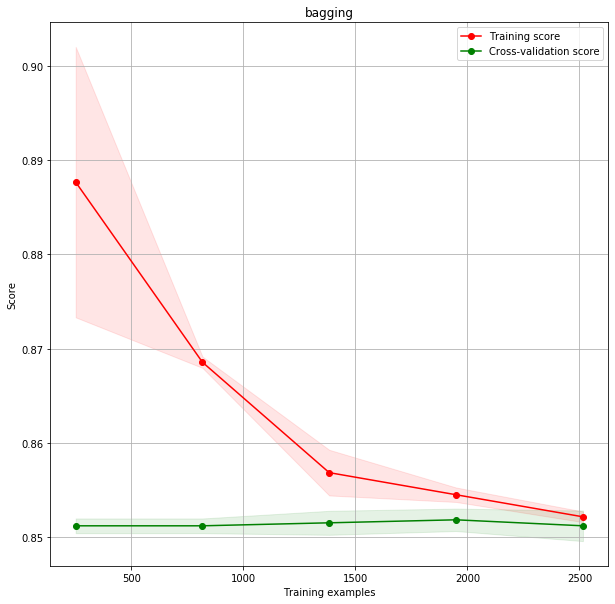

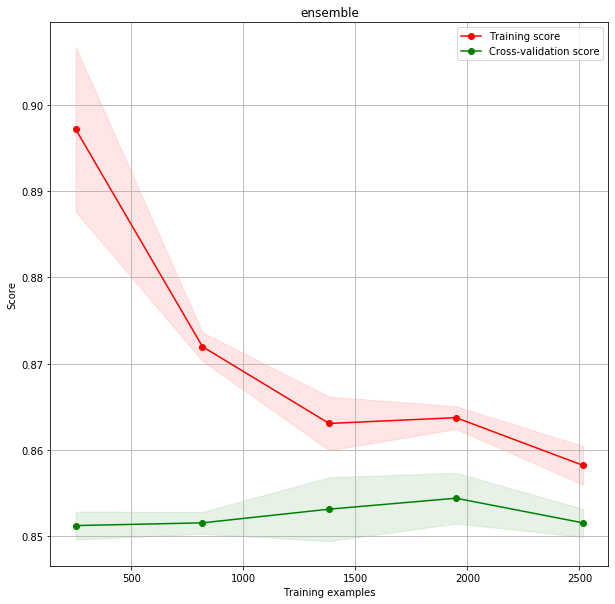

In [50]:
from sklearn.model_selection import learning_curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# Plot all individual models
for i in pred.columns:
    plot_learning_curve(models[i], i, train_x, train_y, cv=None)
#     plt.savefig(i+'_model.png', dpi=100)

# Plot ensemble model
votingC = VotingClassifier(estimators=estimator, voting='soft', n_jobs=4)
plot_learning_curve(votingC, 'ensemble', train_x, train_y, cv=None)

<module 'matplotlib.pyplot' from 'C:\\Users\\batuhan.organ\\AppData\\Local\\Programs\\Python\\Python37\\lib\\site-packages\\matplotlib\\pyplot.py'>

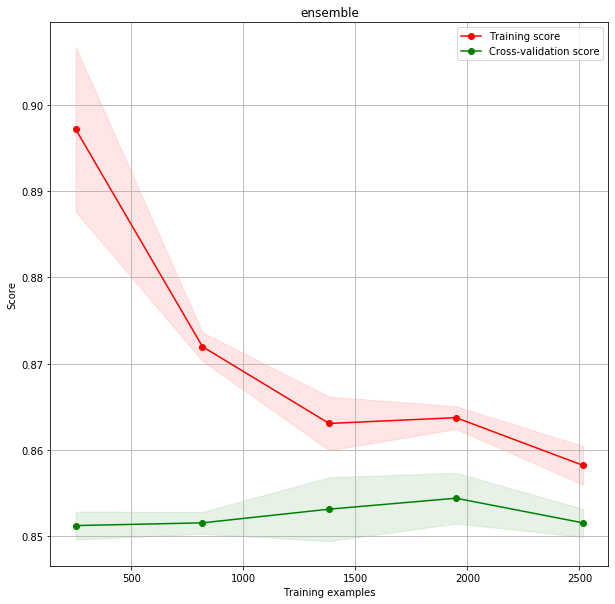

In [41]:
# Plot ensemble model
votingC = VotingClassifier(estimators=estimator, voting='soft', n_jobs=4)
plot_learning_curve(votingC, 'ensemble', train_x, train_y, cv=None)